Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Datasets and Samplers

_Written by: Heng Fang_

In this tutorial, we will introduce how to use datasets and samplers in TorchGeo. 

We will use the [ChesapeakeCVPR](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#torchgeo.datasets.ChesapeakeCVPR) dataset throughout this tutorial.

It's recommended to run this notebook on Google Colab if you don't have your own GPU. Click the "Open in Colab" button above to get started.

## Setup

First, we install TorchGeo.

In [ ]:
%pip install torchgeo
%pip install einops
%pip install matplotlib

## Imports

Next, we import TorchGeo and any other libraries we need.

In [1]:
import tempfile
import os

from torchgeo.datasets import stack_samples

from torch.utils.data import DataLoader

from torchgeo.samplers import RandomGeoSampler, RandomBatchGeoSampler, GridGeoSampler
from torchgeo.datasets import ChesapeakeCVPR

import kornia.augmentation as K

from einops import rearrange
import torch.nn as nn

from typing import Any, Optional

import matplotlib.pyplot as plt

## Datasets

TorchGeo provides a variety of datasets for geospatial machine learning. These datasets are subclasses of `torch.utils.data.Dataset` and can be used with PyTorch's `DataLoader` class.

### ChesapeakeCVPR
The [CVPR 2019 Chesapeake Land Cover](https://lila.science/datasets/chesapeakelandcover) dataset contains two layers of NAIP aerial imagery, Landsat 8 leaf-on and leaf-off imagery, Chesapeake Bay land cover labels, NLCD land cover labels, and Microsoft building footprint labels.

Let's start by loading the MD state split of ChesapeakeCVPR dataset.


In [2]:
class _Transform(nn.Module):
    """Version of AugmentationSequential designed for samples, not batches."""

    def __init__(self, aug: nn.Module) -> None:
        """Initialize a new _Transform instance.

        Args:
            aug: Augmentation to apply.
        """
        super().__init__()
        self.aug = aug

    def forward(self, sample: dict[str, Any]) -> dict[str, Any]:
        """Apply the augmentation.

        Args:
            sample: Input sample.

        Returns:
            Augmented sample.
        """
        for key in ["image", "mask"]:
            dtype = sample[key].dtype
            # All inputs must be float
            sample[key] = sample[key].float()
            sample[key] = self.aug(sample[key])
            sample[key] = sample[key].to(dtype)
            # Kornia adds batch dimension
            sample[key] = rearrange(sample[key], "() c h w -> c h w")
        return sample

In [ ]:
root = os.path.join(tempfile.gettempdir(), 'chesapeake_cvpr')

dataset_train = ChesapeakeCVPR(root, splits=['md-train'], layers=['naip-new', 'lc', 'nlcd'], \
                               transforms=_Transform(K.CenterCrop(224)), download=True)

dataset_val = ChesapeakeCVPR(root, splits=['md-val'], layers=['naip-new', 'lc', 'nlcd'], \
                             transforms=_Transform(K.CenterCrop(224)), download=True)

## Samplers

In order to train a model on a dataset, we need to sample data from the dataset. TorchGeo provides a variety of samplers for geospatial machine learning. These samplers are subclasses of `torch.utils.data.Sampler` and can be used with PyTorch's `DataLoader` class.

In this tutorial, we use `RandomBatchGeoSampler` for the training set and `GridGeoSampler` for the validation set.

In [4]:
train_batch_sampler = RandomBatchGeoSampler(dataset_train, size=224*3, batch_size=8, length=1000)
loader_train = DataLoader(dataset_train, batch_sampler=train_batch_sampler, collate_fn=stack_samples, num_workers=32)

# If we don't scale we get too small images.
val_batch_sampler = GridGeoSampler(dataset_val, size=224*4, stride=224) 
loader_val = DataLoader(dataset_val, sampler=val_batch_sampler, batch_size=8, collate_fn=stack_samples, num_workers=32)

print("Size of training set:", len(loader_train))
print("Size of validation set:", len(loader_val))

Size of training set: 125
Size of validation set: 586


## Visualizing the Dataset

Let's visualize the dataset to see what it looks like. We can use the `plot` method of the dataset to plot a sample.

torch.Size([8, 4, 224, 224]) torch.Size([8, 2, 224, 224])


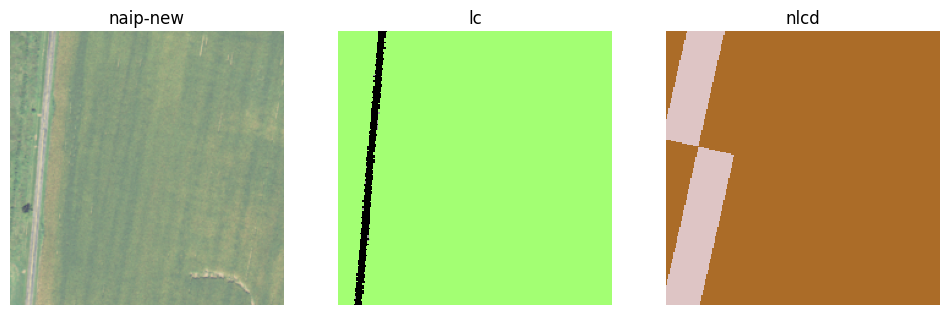

In [5]:
for i, data in enumerate(loader_train):
    images = data["image"]
    targets = data["mask"]
    print(images.shape, targets.shape)

    sample={
        "image": images[0],
        "mask": targets[0]
    }
    fig = dataset_train.plot(sample=sample)
    plt.show(fig)
    break

## Links

If you want to learn the usage of other datasets and samplers, you can refer to the following links:
1. Datasets: https://torchgeo.readthedocs.io/en/stable/api/datasets.html
2. Samplers: https://torchgeo.readthedocs.io/en/stable/api/samplers.html